In [4]:
import sys
try:
    sys.path.remove('/home/adun6414/JModelica/v2_0/JModelica/Python')
    sys.path.append('/home/adun6414/Downloads/PyFMI')
except:
    print(sys.path)
    
import pyfmi
from pandas import *
from H_utility import *
import numpy as np
from numpy import *
import matplotlib.pyplot as mp
import time
from scipy.linalg import block_diag
import scipy as sp
from H_blkdiag import H_blkdiag
import PnP_subfunc
from PnP_subfunc import H_vec
import scipy as sp
import scipy.interpolate
import control.matlab as ctool
from H_simobj import H_simobj
import os

In [5]:

currentdir='/home/adun6414/Work/CERC_UCM'
os.chdir(currentdir)


# configuration
dt=30*60; # 30 min sampling time
start_time=H_date2simtime(to_datetime('2018-08-01 00:00'),'2018')
final_time=H_date2simtime(to_datetime('2018-08-06 23:50'),'2018')
simtimes=arange(start_time,final_time,dt)
simtimedate=date_range(start=H_simtime2date(start_time,'2018'),end=H_simtime2date(final_time,'2018'),freq=str(int(30*60./60))+'T')

key_x='x0'
x0_val=0.2; # initial state of charge
# inputs (controllable variables)
key_u=['ChillerON','SP_mCH', 'TCHeSP']
# inputs: disturbance
key_w=['BuildingCoolingLoads', 'ER', 'PnonHVAC', 'Psolarpv']
# outputs of interests
key_y=['Output[1]','Output[2]','Output[3]','Output[4]','Sensor_TCHWS.T','Sensor_TCHWR.T','Sensor_msup.m_flow','Sensor_mCHi.m_flow','Sensor_mS.m_flow','time',
      'Sensor_Tstorage[1].y','Sensor_Tstorage[2].y','Sensor_Height[1]','Sensor_Height[2]','Sensor_Height[3]']

testcase=2
if testcase==1:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_Only_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_Only_V2_MPC.mo'
elif testcase==2:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_CoolingTower_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_CoolingTower_V2_MPC.mo'

idmodel=('CASE900Load1576283834') # not used for UC-Merced

obj=H_simobj(dt=dt,start_time=start_time,final_time=final_time,modelname=modelname,modelicafile=modelicafile,
             fmu='./Merced_CoolingPlantNew_Chiller_Storage_Only_V2_MPC.fmu',
             idmodel=idmodel,key_u=key_u,key_w=key_w,key_y=key_y,key_x=key_x)
             
#% data loading and resampling
os.chdir('/home/adun6414/Work/CERC_UCM/Fig_n_data')
filename='DATA8to8.csv' #filename='DATA8to9.csv'
DATARAW=read_csv(filename).set_index('Date')
DATARAW=DATARAW.set_index(to_datetime(DATARAW.index)) # change 'str' to datetime obj
DATARAW['time']=H_date2simtime(DATARAW.index,'2018')
dummy=DATARAW.reindex(simtimedate,method='nearest') # resample or reindex
DATA=dummy[['time','QBL','Twb','QCHLsum']].fillna(method='ffill')
DATA['Pow']=dummy[['PCHsum','PCTtot']].sum(axis=1)
del DATARAW, dummy
os.chdir(currentdir)


In [8]:
#% specify disturbances
t_schedule=simtimes

CHON=H_schedule(t_schedule,array([7,19]),1,1)
mEva_flow_nominal=obj.fmuinpy.get('mEva_flow_nominal')
SP_mCH=H_schedule(t_schedule,array([7,19]),0.*mEva_flow_nominal,0.9*mEva_flow_nominal)
TCHeSP=H_schedule(t_schedule,array([7,19]),4,4) # C
QBL=H_iscolumn(DATA['QBL'].to_numpy()) # kW
ER=H_schedule(t_schedule,array([7,19]),2,1) #$/kWh
PnonHVAC=H_schedule(t_schedule,[7,19],0*1000,0*1000) # kW
Psolarpv=H_schedule(t_schedule,[7,19],0*500,0) # kW
          
u=hstack((CHON,SP_mCH,TCHeSP))
w=hstack((QBL,ER,PnonHVAC,Psolarpv))

schedule={'u': u, 'w': w, 't': H_iscolumn(t_schedule)}
# conventional control simulation
(res,IN0)=obj.simulate_schedule(x0_val,schedule)

Final Run Statistics: --- 

 Number of steps                                 : 1630
 Number of function evaluations                  : 2738
 Number of Jacobian evaluations                  : 66
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 241
 Number of nonlinear iterations                  : 2645
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1848
 Number of state events                          : 23

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-06 3.e-04
 3.e-04]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 18833400.0 seconds.
Elapsed simulation time: 0.2754209460108541 seconds.


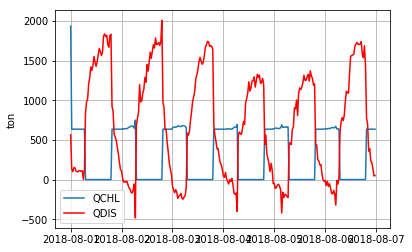

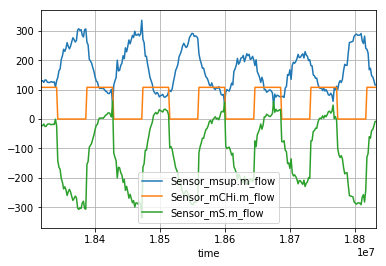

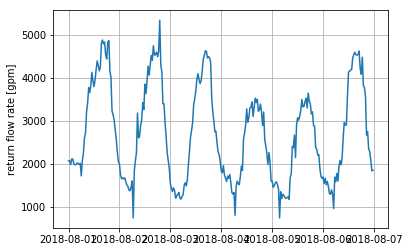

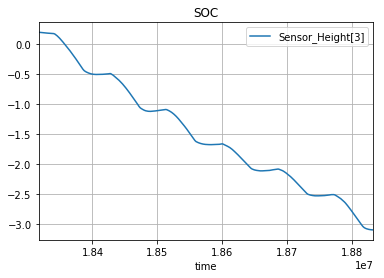

In [28]:
data=DataFrame(columns=obj.key_u+obj.key_y+obj.key_w)  
for k in obj.key_u+obj.key_y+obj.key_w:
    data[k]=res[k]
data.index=data.time
figure(100)
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[3]']))     
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[4]']),'r')
legend(['QCHL','QDIS'])
ylabel('ton')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if '.m_flow' in k])
grid(True)

figure(102)
plot(to_datetime(H_simtime2date(data['time'],'2018')),data['Sensor_msup.m_flow'].apply(kgs2gpm))
ylabel('return flow rate [gpm]')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if 'Height[3]' in k])    
title('SOC')
grid(True)
